In [45]:

import numpy as np
import sys
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation
#from matplotlib.animation import FFMpegWriter
from matplotlib.animation import FuncAnimation

# System setup:

#In PIC, the time step and the grid size must be well chosen, 
#so that the time and length scale phenomena of interest are properly resolved in the problem. 
#In addition, time step and grid size affect the speed and accuracy of the code



NAME = 'two-stream_instability'    # name of setup configuration

CELLS = 100    # number of cells
#CELLS = 200
NODES = CELLS + 1    # number of nodes. 1 dimension +1 (grid points+1)
SIZE = 20    # size of system (grid length)
STEPS = 2000    # number of time steps; how long to sim for
#STEPS = 4000
#q_over_me=-1.0       # electron charge:mass ratio


# Integration steps:
dX = SIZE/CELLS   # distance between nodes in space (grid length / grid points or nodes)
dT = 0.1    # timestep 

# Particles:
NPpc = 20    # number of particles per species per cell
NP = NPpc * CELLS    # number of particles of a species (total number of particles)

# SOR: potential solver
ERROR = 1e-5 #Poisson solver tolerance to make sure the solution converges 

# Plasma Parameters and Pertubation: To see whether the perturbation amplitude affects instabilities
omegaP = 1    # normalized plasma frequency 
eps0 = 1     # normalized vacuum permittivity

MODE = 1    # could use different pertubation modes
#AMPLITUDE = 1e-1    # amplitude of plasma pertubation (Perturbation magnitude (1e-4)) << first attempt
AMPLITUDE = 1e-3 #lower amplitude


In [46]:
#########################################################
#Grid and Particle Stream Generation Class and Functions: 
########################################################



#From particle pusher/mover: where we have to generate particles with position, velocity ..etc 
#in order to calculate the charge density on nodes

#PIC: Particle methods simulate a plasma system by following a number of particle trajectories

#Essential physics can be captured with a much smaller number of particles than that in a real plasma:
#a) For 10^3 ~ 10^11 particles: The charge/mass ratio and charge density remain the same. 


import numpy as np

# Particle class 

class Particle:
    
    # Initialize particle object
    def __init__(self, position, velocity, frequency, charge_over_mass, move_boolean, num_particles):
        
        # particle methodes
        self.x = position
        self.v = velocity
        self.omega = frequency
        self.q = omegaP**2 * (1/charge_over_mass) * eps0 * (SIZE/num_particles) #computational particle charge
        #solving for q from the equation of plasma frequency omegap^2 (shown in my notes) in SI units: rad/s
        self.qoverm = charge_over_mass 
        self.move = move_boolean # background charge given by background (not moving) ions
    
    # Two stream setup:
    def two_stream_instability ():
        
        # array of particle objects in streams
        STREAM = [] #an empty list
        
        # separation/ particle spacing
        separation = 1.0 * SIZE/(NP/2) 
        
        # for loop through all flucuating particles:
               
    #Plasma oscillations: A longitudinal plasma wave manifests itself as a disturbance in the electron density:
   # ne = n0 + n1(x,t). 
#We can excite such a wave numerically by displacing the initial positions of the particles.


        for i in range(NP//2): #Integer Division): Quotient when a is divided by b, rounded to the next smallest whole number
            
            # plasma flucuations are modelled as a background value (usually constant) plus a small pertubation
            # plasma background
            x_background = (i + 0.5) * separation # Python ndarrays ( N-dimensional array) start at index 0
 #>>> Particles are loaded offset from a uniformly distributed center:  

            # plasma pertubation
            angle_theta = 2 * np.pi * MODE * x_background / SIZE
            plasma_pert = AMPLITUDE * np.cos(angle_theta) #Include small perturbation
            
            # overall plasma flucuation
            x_1 = x_background + plasma_pert
            x_2 = x_background - plasma_pert
        
            # to cover all space and visit all nodes we need periodic boundary conditions:
            # periodic boundaries: 
                #plasma_start = 0.
                #plasma_end = grid_length
                #wall_left = 0. (plasma start)   #wall left = dx/2
                #wall_right = grid_length
                
    # loop over all particles to see if any have
    # left simulation region: if so, we put them back again
    # according to the switch 'particle'
            if x_1 < 0:
                x_1 += SIZE
            if x_2 < 0:
                x_2 += SIZE
            if x_1 >= SIZE:
                x_1 -= SIZE
            if x_2 >= SIZE:
                x_2 -= SIZE
#The B.C here are periodic: particles are transported to the opposite side of the domain
               
            # add flucuating/moving particles to stream
            STREAM.append(Particle(x_1, -1.0, 1.0, -1.0, True, NP))
            STREAM.append(Particle(x_2, 1.0, 1.0, -1.0, True, NP))
            
#Drift velocity of species 1 (1)
#Drift velocity of species 2 (-1) << opp direction
            
        # for loop for all background particles: background meaning (not moving) ions/particles
        separation = SIZE/NP 

        for i in range(NP):
            
            # plasma background
            x_background = (i + 0.5) * separation
            
            # add stationary particles to stream
            STREAM.append(Particle(x_background, 0.0, 1.0, 1.0, False, NP)) #False for the "move_boolean"
        
        # return stream of objects
        return STREAM
    



In [47]:
######################### 
#PIC Main Loop Functions:
#########################

# Functions for four step PIC process using SOR. We will need six functions.

###### 1) Density weighting/averaging on nodes of grid: 
#particle positions are scattered to the grid

# Function takes in array of particles [particles]. INPUT = [particles]
# Function outputs density on nodes in grid. OUTPUT = rho 


def density(particles):
    
    rho = np.zeros(NODES)        # creates array rho with NODES number of values, each equal to 0.0 
   
    length_particles = len(particles)
     # map charges onto grid:
    for j in range(length_particles):
        
        # setup particle position, step, and distance values that are used for indexing
        
        position = (particles[j].x / dX) #position here define the position of a particle in terms of cells (how many cells away is this particle)
        #dX: distance between nodes in space, size of one mesh
        
        #particles/dX:  charge weighting factor 
        step = np.floor(particles[j].x / dX) #np.floor: rounds down to closest int cause position most likely a non int
        
        #step is j along y
        distance = position - step #only contribution comes from the adjacent points so more than cell away the distance is same
        #original distance minus the nearst lower node: takes position in cells 
        # setup current and next index values 
        current_index = int(step)
        next_index = (current_index + 1)
        
        # add current and next rho charge (q) values: compute rho at each node:
        rho[current_index] += particles[j].q * (1.0 - distance) #since everything is normalized to dX and in units of cells 
        #we say the cell is 1 therefore 1.0 - distance is distance 
        rho[next_index] += particles[j].q * distance

        
    # to get right values in right places for repeating iterations: 
    # periodic boundaries: Because last and first nodes are the same  
    rho[NODES - 1] += rho[0]
    rho[0] = rho[NODES - 1]

    # create numpy array of rho values
    rho = np.array(rho)

    rho /= dX    #rho = rho/dX: divide by cell/mesh size to get charge density
    return rho


In [48]:
###### 2) Successive Over-Relaxation Method to solve Poisson Equation.
#the coefficient must be bounded so 1< w <2 and usually 1.5 is a good starting 

# Function takes in density (rho) array. INPUT = rho 
# Function outputs electric potential (phi) array. OUTPUT = phi
def SOR(rho):
    
#To optimize the solution the over-relaxation parameter that converges the fastest when it is set to:
    w = 2.0 / (1 + np.pi / NODES) #relaxation constant w
    
    
    # create initial starting phi values
    phi = np.zeros(NODES)

    # create matrix b (see SOR description above) from density array rho
    matrix_b = -np.copy(rho) * dX**2 / eps0 #np.copy(): Return an array copy of the given object
#matrix b = charge density 
#linear charge density: multiplied by the area of one box (cell) cause charge density is usually volume
#


    # SOR solver
    for k in range(10000): #a max 10,000 iterations were used
        
        if k == 9999:    # if loop  gets to k = 9999 without finding acceptable solution (low enough error) then we have problem. 
                         # if k = 9999 then terms are not converging and SOR method fails
            print ("\nSOR is likely to diverge\n")
        phi_new = np.copy(phi)
        
        for i in range(NODES - 1): #nodes-1 = cells 
            
            # create next and previous indices 
            next_index = (i + 1) if (i < NODES - 2) else 0
            previous_index = (i - 1) if (i > 0) else (NODES - 2)
            
            # SOR algorithm. See eqs in SOR section 
            phi_new[i] = (1 - w) * phi[i] + (w / -2.0) * (matrix_b[i] - phi_new[previous_index] - phi[[next_index]])
        #-2 is the constant aii in the Laplacian matrix
# checking convergence
        if k % 25 == 0:
            if np.max(np.abs(phi_new - phi)) < ERROR:
                phi = phi_new
                break
        phi = np.copy(phi_new)

    phi[NODES - 1] = phi[0] # move on to next
    
    return phi


In [49]:
####### 3) Calculating the electric field from the potential on nodes in grid

#   Function takes in array of the potential on nodes. INPUT = phi
#   Function outputs in array of electric fields on the nodes. OUTPUT = electric field on nodes array

def field_on_nodes (phi):
    
    # initial electric field values
    electric_field = np.zeros(NODES)
    
    for i in range(NODES):
        next_index = (i + 1) if (i < NODES - 1) else 0 #move to next index only if the next one is less than the last 
        previous_index = (i - 1) if (i > 0) else (NODES - 1)

        electric_field[i] = (phi[previous_index] - phi[next_index]) / (2 * dX) 
        #divide by cell/mesh size to get electric field

    return electric_field

In [50]:
####### 4) Assign the electric field values from nodes to particles. Interpolate field from nodes to particles.

# Function takes in array of electric field on nodes and array of particles.
#INPUT = array of electic field on nodes, and array of particles
# Function outputs array of electric field on particles. 

def field_on_particles (field, particles):
    
    length_particles = len(particles)
    
    # create initial electric field array
    electric_field = np.zeros(length_particles)
    
    for k in range(length_particles):
        
        if particles[k].move: #self.move = move_boolean
            
            position = (particles[k].x // dX) #dX: distance between nodes in space (a mesh space)
            #self.x = position 
            step = np.floor(particles[k].x // dX) #floor rounds down floats to int

            next_index = (step + 1) if (step + 1) < NODES else 0

            electric_field[k] = (next_index - position) * field[int(step)] + (position - step) * field[int(next_index)]
            
    return electric_field

In [51]:
######## 5) Equations of motion integration

#   Function takes in electric field and particles array. INPUT = field and array array
#   Function outputs new particles velocities and positions. OUTPUT = particle velocities and positions.

def move_particles(field, particles):
    
    length_particles = len(particles)
    
    for k in range(length_particles):
        if particles[k].move:
#the particle push is given by these two equations (updating new velocities and positions): The leap-frog     
            # update new velocity
            particles[k].v += field[k] * particles[k].qoverm * dT 

            # updating position
            particles[k].x += particles[k].v * dT 

            # boundardy conditions
            while particles[k].x < 0:
                particles[k].x += SIZE
            while particles[k].x >= SIZE:
                particles[k].x -= SIZE
                
    return particles

In [52]:
###### 6) Function for rewinding velocity by dT/2 forward or backward

#   Function takes in rewind direction, field, and particles arrays. INPUT = rewind direction, field, particles
#       direction forward: +1
#       direction backward: -1
#   Function outputs new particle velocities. OUTPUT = new particles velocties

def rewind(direction, field, particles):
    
    length_particles = len(particles)
    
    for k in range(length_particles):
        
        # updating new velocity
        if particles[k].move: 
            
            particles[k].v += direction * field[k] * particles[k].qoverm * dT / 2.0 
            
    return particles

In [53]:
################
################

#Progress Bar

###############
###############

#Print iterations progress

import sys

def printProgress (iteration, total, prefix = '', suffix = '', decimals = 2, barLength = 100):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : number of decimals in percent complete (Int)
        barLength   - Optional  : character length of bar (Int)
    """
    filledLength    = int(round(barLength * iteration / float(total))) 
    percents        = round(100.00 * (iteration / float(total)), decimals)
    bar             = u'\u2588' * filledLength + '-' * (barLength - filledLength) 
    #u2588: Unicode Character 'FULL BLOCK' 
    sys.stdout.write('\r%s |%s| %s%s %s' % (prefix, bar, percents, '%', suffix)),
    #%s: It is a string formatting syntax ( Python borrows from C).
    sys.stdout.flush()
    if iteration == total:
        sys.stdout.write('\n') #
        sys.stdout.flush()
        

In [54]:
######################
######################

#PIC Function Calls

######################
######################

# Main

# Function to check file NAME 
# if file parameters exist, generate initial particles

if NAME == 'two-stream_instability':
    
    # calling Particle class to generate initial particles
    particles = Particle.two_stream_instability()
    
else:
    print('Invalid two-stream_instability, no parameters exist for input two-stream_instability given')
    


# PROGRESS BAR
stp = 0
printProgress(stp, STEPS, prefix = 'Progress:', suffix = 'Complete', barLength = 50)


# core PIC loop
for step in range(STEPS):
    
    # PIC Steps
    
    # 1) Assign densities
    rho = density(particles)
    
    # 2) SOR method to solve Poisson and calculate phi values
    phi = SOR(rho)
    
    # 3) Assign the electric field values from nodes to particles
    electric_field_nodes = field_on_nodes(phi)
    
    # 4) Calculate electric field on particles 
    electric_field_particles = field_on_particles(electric_field_nodes, particles)

    if step == 0:
        particles = rewind(-1, electric_field_particles, particles)

    particles = move_particles(electric_field_particles, particles)
    # WRITE TO FILES
    
    if step % 1 == 0:
    
        # print "step: ", step
    
        output = open('/Users/lujainali/Documents/GitHub/Two_Stream_Instability/4000Data/' + 'step_' + str(step) + '.dat', 'w')
    
        newparts = rewind(1, electric_field_particles, particles)
        length_particles = len(particles)
    
        # write to write
        for i in range(length_particles):
            if newparts[i].move:
                output.write(str(newparts[i].x) + ' ' + str(newparts[i].v) + '\n')
        output.close()
    
    # PROGRESS BAR
    stp += 1
    printProgress(stp, STEPS, prefix = 'Progress:', suffix = 'Complete', barLength = 50)

Progress: |██████████████████████████████████████████████████| 100.0% Complete


KeyboardInterrupt: 

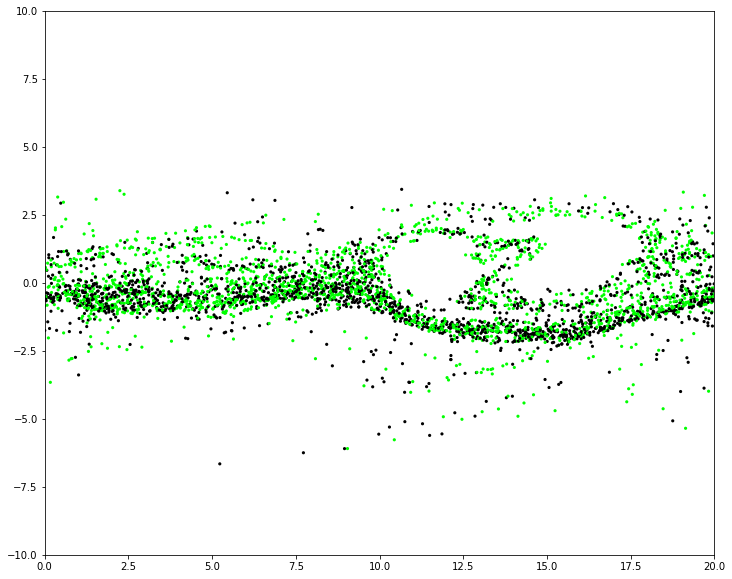

In [44]:
###################
###################

#Animation 

##################
#################


# import animation libraries 
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib.animation import FFMpegWriter
from matplotlib.animation import FuncAnimation



# call ffmpeg writers: FFMpegWriter(fps=5, codec=None, bitrate=None, extra_args=None, metadata=None)
#fps: Framerate for movie.
#bitrate: for the saved movie file, which is one way to control the output file size and quality.
#Set up formatting for the movie files:
plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'
writer = animation.writers['ffmpeg'] 
writer = writer(fps=30, bitrate=1800) #fps = 15
# sizing
fig = plt.figure() #fig: The figure object that contains the information for frames
fig.set_size_inches(12, 10)
ax = plt.axes(xlim=(0, SIZE), ylim=(-10, 10)) #SIZE: grid length

# scatter plot
#adding lines and size of scatter points 
scat = ax.scatter([], [], lw=0, s=10) #linewidth =0
#adding labels: label = ('line {}'.format(i)) inside the scat 
# or in the for loop init() inside:

colors_ini = np.zeros((NP, 3)) #np.zeros((rows,cols)) 
#plt.legend(loc='upper left', frameon=False)


#Update the scatter collection, with the new colors, sizes and positions:

#initialization function: plot the background of each frame
def init():
    scat.set_offsets([]) 
#I'm updating the plot using set_offsets inside the plot function which is called by animation
    return scat

# define colors for particles
def getColor(vel):
    for i in range(len(vel)): #colors RGB code #red and blue for 2000 try green and black 
        if vel[i] < 0:
            colors_ini[i] = [0,1,0]
        else:
            colors_ini[i] = [0,0,0] #0-0-0 Black  
    return colors_ini
# read data files and animate

#Last step is to tell matplotlib to use this function (scatter plot) as an update function 
#for the animation and display the result or save it as a movie:

def animate(i):
    
    # location of storage data files
    filename = '/Users/lujainali/Documents/GitHub/Two_Stream_Instability/4000Data/' + 'step_' + str(i) + ".dat"
    #save as .dat a generic data file formate (binary or text)
    
    # unpack data into two arrays; one for position and one for velocity 
    pos, vel = np.loadtxt(filename, delimiter=' ', unpack=True) #np.loadtext: Load data from a text file.
    #delimiter: the string used to separate values. By default, this is any whitespace.
    #unpack is bool: If True, the returned array is transposed so that arguments unpacked using x, y, z = loadtxt(...)
    
    
    
    # copy data to numpy array: load or save all the datafiles in a numpy array
    data = np.array([pos, vel]).copy().T
    
    # generate colors
    if i == 0:
        colors = getColor(vel)
    else:
        colors = colors_ini
    
    # create scatter plot from data and colors
    scat.set_offsets(data)
    scat.set_color(colors)
    return scat

# call the animator.  blit=True means only re-draw the parts that have changed.
#We've chosen a "STEPS" or 2000 frame animation with a 1ms delay between frames. 
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=STEPS, interval=1)
# save the animation as an mp4.  This requires ffmpeg installed using Homebrew 

anim.save('/Users/lujainali/Documents/GitHub/Two_Stream_Instability/Animation/' + str(STEPS) + ' Step' + '.mp4', writer=writer)
# + '.mp4': saves the given file as an mp4 format 
print('animation file is ready')

In [ ]:
#Checks: Plot the conservation laws 

#plt.close() will close the figure window entirely,
#where plt.clf() will just clear the figure - you can still paint another plot onto it.

#mass = particles.q/particles.qoverm #mass = charge/q_over_me  #  pseudo-particle mass (need for kinetic energy diagnostic) 

mass =1 
ukin=np.zeros(nsteps+1)
upot=np.zeros(nsteps+1)
utherm=np.zeros(nsteps+1)
udrift=np.zeros(nsteps+1)
utot=np.zeros(nsteps+1)

def diagnostics():      
    global rho,electric_field,CELLS,itime,SIZE,AMPLITUDE #,rho0
    global ukin, upot, utot, emax
    global igraph
    xgrid=dX*np.arange(CELLS+1)
    if (itime==0):   #itime = 0  initialise time counter
        plt.figure('Fields')
        plt.clf()
    if (igraph > 0):
      if (np.fmod(itime,igraph)==0): # plots every igraph steps
    # Net density
        plt.subplot(2, 2, 1)
        if (itime >0 ): plt.cla()
        plt.plot(xgrid, -(rho), 'r', label='Density')
        plt.xlabel('x')
        plt.xlim(0,SIZE)
        plt.ylim(-2*AMPLITUDE,2*AMPLITUDE)
        plt.legend(loc=1)
    # Electric field
        plt.subplot(2, 2, 2)
        if (itime >0 ): plt.cla()
        plt.plot(xgrid, electric_field, 'b', label='Ex')
        plt.xlabel('x')
        plt.ylim(-2*AMPLITUDE,2*AMPLITUDE)
        plt.xlim(0,SIZE)

        plt.legend(loc=1)



#   total kinetic energy
    v2=v**2
    #vdrift=sum(v)/npart
    ukin[itime] = 0.5*mass*sum(v2)
    #udrift[itime] = 0.5*mass*vdrift*vdrift*npart  
    #utherm[itime] = ukin[itime] - udrift[itime]
    
# potential energy 

    e2=electric_field**2
    upot[itime] = 0.5*dx*sum(e2)
    emax = max(Ex) # max field for instability analysis */
    
# total energy
    utot[itime] = upot[itime] + ukin[itime]
    
    return True #return utot

####


def histories():

#FILE *history_file;     /* file for writing out time histories */            

  global ukin, upot, utot, udrift, utherm
  xgrid=dt*np.arange(nsteps+1)
#  plt.clf()
  plt.figure('Energies')
#  plt.subplot(2, 2, 1)
  plt.plot(xgrid, upot, 'b', label='Upot')
  plt.plot(xgrid, ukin, 'r', label='Ukin')
  plt.plot(xgrid, utot, 'black', label='Utot')
#  plt.plot(xgrid, udrift, 'g', label='Udrift')
  plt.xlabel('t')
  plt.ylabel('Energy')

#  plt.xlim(0,grid_length)
#  plt.ylim(-2*a0,2*a0)
  plt.legend(loc=1)
 # plt.savefig('energies.png')

#   write energies out to file */
#  np.savetxt('energies.out', np.column_stack((xgrid,upot,ukin,utot)),fmt=('%1.4e','%1.4e','%1.4e','%1.4e'))   # x,y,z equal sized 1D arrays
#  fohist = open("energies.data","w")
#  str.format("{0:<10.5f}", 3.14159265)
#   if (itime==1) {fprintf(history_file, " t, U_drift, U_therm, U_field, U_total, Emax\n");}
#   fprintf( history_file, "%f  %e %e  %e  %e %e\n", itime*dt, udrift, utherm, upot, utot, emax );

